# Advanced Python: BYONN, Part II
**B**uild **Y**our **O**wn **N**eural **N**etwork

<center>
<img src="./pictures/cajal_glial.jpg" style="width:480px;height:626px;">
<br>
<i>Glial cells of the cerebral cortex of a child (Santiago Ramón y Cajal, 1904)</i>
</center>

Recall that in the last session, we saw how to build a simple neural network using `Layer`s and `Module` objects in `pytorch`. Here, we will build a similar network to classify the MNIST dataset.

References:
- [Feed-Forward Neural Network (FFNN) — PyTorch](https://medium.com/@carlosrodrigo.coelho/feed-forward-neural-network-ffnn-pytorch-d5d9759f53d2)

In [12]:
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [13]:
# load training set
mnist_train = MNIST(root='data/', train=True, download=True, 
                    transform=transforms.ToTensor()) 
                    # needs to transform img>tensor
# load testing set
mnist_test = MNIST(root='data/', train=False, download=True,
                   transform=transforms.ToTensor()) 

### Warm up:
`mnist_train` and `mnist_test` are iterables (you can index them like a list). Each item is a tuple of (image, label) pair.

1. Figure out what's the shape of the images.
2. How many images are there in the training set? How about the testing set?
3. How many classes are there in the dataset?

In [18]:
(image, label) = mnist_train[0] # get first image and label
print(f'image shape: {image.shape}, label: {label}')

image shape: torch.Size([1, 28, 28]), label: 5


In [ ]:
len(mnist_train), len(mnist_test)  # number of training and testing samples

In [20]:
# modify the following variables to match the dataset
n_inputs = image.shape[0] * image.shape[1] * image.shape[2]  # 1*28*28 for MNIST
n_classes = 10

In [27]:
batch_size = 100

# use pytorch DataLoaders to automatically load/feed data during train/test
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size, 
                                          shuffle=False)

### Exercises:

Define a neural network object from `pytorch` that consists of 1 hidden layer with 56 neurons and ReLU activation function. Importantly, the network should be able to take in images and output a vector of probabilities for each class. 

In [28]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(n_inputs, n_hidden) # first layer: inputs to hidden
        self.relu = nn.ReLU() # activation function (ReLU)
        self.l2 = nn.Linear(n_hidden, n_classes) # hidden to output

    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
    
        return out

In [29]:
n_hidden = 56

# initialize instance    
model = NeuralNet(n_inputs, n_hidden, n_classes)

With the neural network defined, we can now train it on the MNIST dataset.

In [30]:
# loss and optimizer
# makes sense to use cross entropy loss because we are training for discrete
# category classifications (also could write our own loss function)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
n_epochs = 10

# training loop
n_total_steps = len(train_loader) # number of batches in training set

# for storing lost history
loss_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    for i, (images, labels) in enumerate(train_loader):
        # reshape images to (batch_size, input_size)
        # eg: 256,1,28,28 -> 256,784
        images = images.reshape(-1, 28**2)
        labels = labels

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # saving the loss at current pass to log
        epoch_loss.append(loss.detach().numpy()) # save value

        # backward pass
        optimizer.zero_grad() # set gradients to zero in every batch
        loss.backward()     # backpropagation
        optimizer.step()   # update weights

        if (i+1) % 100 == 0: # print every 100 steps
            print(f'epoch {epoch+1}/{n_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
    
    # save mean loss of the epoch
    loss_hist.append(np.mean(np.array(epoch_loss)))

print('Finished training')

epoch 1/10, step 100/600, loss = 0.8391
epoch 1/10, step 200/600, loss = 0.5677
epoch 1/10, step 300/600, loss = 0.3694
epoch 1/10, step 400/600, loss = 0.4016
epoch 1/10, step 500/600, loss = 0.3343
epoch 1/10, step 600/600, loss = 0.3748
epoch 2/10, step 100/600, loss = 0.2895
epoch 2/10, step 200/600, loss = 0.3546
epoch 2/10, step 300/600, loss = 0.2983
epoch 2/10, step 400/600, loss = 0.2338
epoch 2/10, step 500/600, loss = 0.3906
epoch 2/10, step 600/600, loss = 0.3491
epoch 3/10, step 100/600, loss = 0.2763
epoch 3/10, step 200/600, loss = 0.2277
epoch 3/10, step 300/600, loss = 0.1851
epoch 3/10, step 400/600, loss = 0.2308
epoch 3/10, step 500/600, loss = 0.2759
epoch 3/10, step 600/600, loss = 0.1857
epoch 4/10, step 100/600, loss = 0.2194
epoch 4/10, step 200/600, loss = 0.1231
epoch 4/10, step 300/600, loss = 0.2247
epoch 4/10, step 400/600, loss = 0.1230
epoch 4/10, step 500/600, loss = 0.1999
epoch 4/10, step 600/600, loss = 0.1656
epoch 5/10, step 100/600, loss = 0.0905


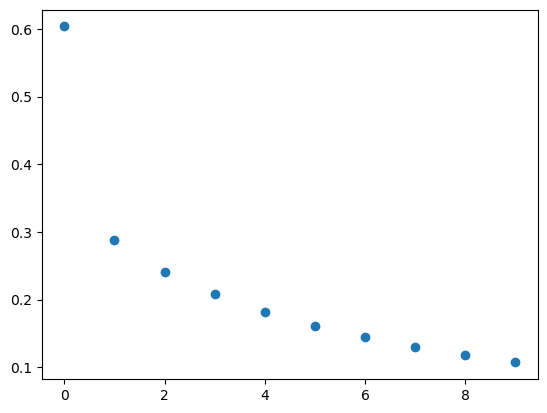

In [32]:
plt.plot(loss_hist, "o")

In [33]:
# test the model
with torch.no_grad(): # we don't need gradients in the testing phase
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28**2)  # 100,1,28,28 -> 100,784
        labels = labels          # 100,1 -> 100
        outputs = model(images)  # 100,10

        # value, index
        _, predictions = torch.max(outputs, 1) # 1 is the dimension
        n_samples += labels.shape[0] # number of samples in the current batch
        n_correct += (predictions == labels).sum().item()  # number of correct predictions

    acc = 100.0 * n_correct / n_samples  # accuracy
    print(f'accuracy = {acc}')

accuracy = 96.53
